In [1]:
%load_ext autoreload
%autoreload 2

# imports


In [15]:
from os.path import join
from collections import namedtuple
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import pickle
from tools import get_mids, array_source_interp
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from scipy.optimize import fmin_l_bfgs_b
from scipy.special import erfinv
from scipy.stats import chi2

from fluxes import atmo_background
from fluxes import astro_flux
from settings import ngc1068, BASEPATH
from scipy.interpolate import RegularGridInterpolator


matplotlib = sns.mpl
plt = matplotlib.pyplot
plt.style.use(join(BASEPATH, "style.mplstyle"))
warnings.filterwarnings("ignore")

# loading effective areas


In [3]:
sindec_bins, logE_bins, aeffs = pd.read_pickle(
    join(BASEPATH, "resources/aeff_cluster_nuecc_with-eq.pickle")
)


## binning

In [4]:
aeff_test = aeffs.iloc[100]["equatorial"] # for testing
logE_mids = get_mids(logE_bins)
ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")

40 log_10(energy) bins
39 declination bins


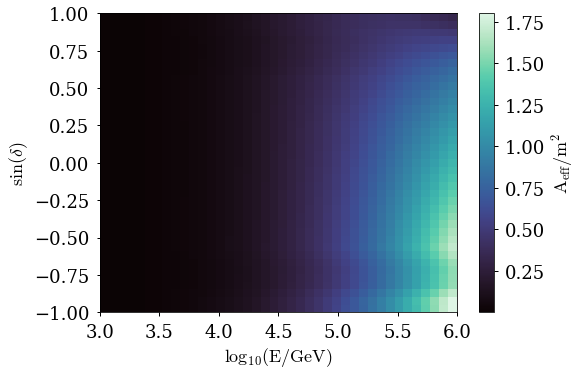

In [5]:
plt.pcolormesh(logE_bins, sindec_bins, aeff_test.T * 1E-4)#, norm=LogNorm())
plt.xlabel(r"$\rm log_{10} (E/GeV)$")
plt.ylabel(r"$\rm sin(\delta)$")
cb = plt.colorbar()
cb.set_label(r"$\rm A_{eff} / m^2$")


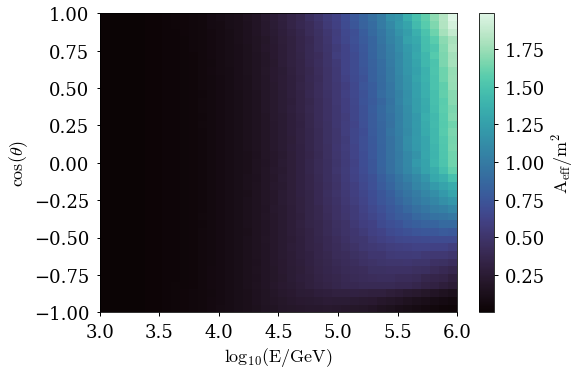

In [6]:
plt.pcolormesh(logE_bins, sindec_bins, aeffs.iloc[100]["aeff_hist"]) #, norm=LogNorm())
plt.xlabel(r"$\rm log_{10} (E/GeV)$")
plt.ylabel(r"$\rm cos(\theta)$")
cb = plt.colorbar()
cb.set_label(r"$\rm A_{eff} / m^2$")



# background

In [7]:
# MCEQ
with open(join(BASEPATH, "resources/MCEq_flux.pckl"), "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
# load total nue+nuebar + nutau+nutaubar
# (nutau+nutaubar is practically zero)
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))),
    np.log(flux_def["nue_total"] + flux_def["nutau_pr"]),
)
ee, ss = np.meshgrid(emids, sindec_mids)
spl_vals = np.exp(rgi((ee, ss)))


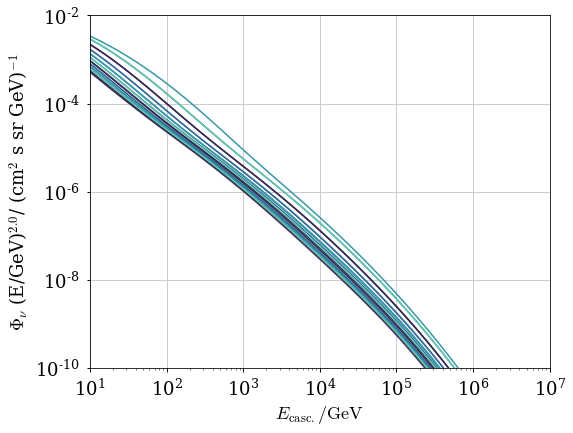

In [8]:
spec = 2.0
fig, ax = plt.subplots(figsize=(8, 6))
for ti, ang in enumerate(zen):
    p0 = ax.loglog(
        e_grid,
        e_grid ** (spec) * flux_def["nue_conv"][:, ti],
        ls="solid",
        lw=1.5,
    )

ax.set_xlim(10, 1e7)
ax.set_ylim(1e-10, 1e-2)
ax.set_xlabel(r"$E_{\rm casc.} / {\rm GeV}$")
ax.set_ylabel(
    r"$\Phi_{\nu}$ (E/GeV)$^{" + str(spec) + " }$" + "/ (cm$^{2}$ s sr GeV)$^{-1}$"
)
fig.tight_layout()


# NGC1068 - source parameters

In [9]:
from copy import copy

In [10]:
# livetime of 10yr in seconds
LIVETIME = 365 * 10 * 24 * 3600
# 10yr PS PAPER PARAMETERS
GAMMA_NGC = 3.2
PHI_NGC = 5E-14 * 2 # numu + numubar -> nue+nuebar + nutau+nutaubar
E0_NGC = 1E3

# analysis region in distance to source
delta_psi = 4


In [13]:

# generic source config without dec coordinate
src_config = dict(
    sindec_mids=sindec_mids,
    livetime=LIVETIME,
    ewidth=ewidth,
    dpsi_max=0,
    grid_2d=1,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = delta_psi
bg_config["grid_2d"] = 1

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = ngc1068.dec.rad


## calculate number of events for ngc-like source

In [11]:
n_events = pd.read_pickle(join(BASEPATH, "resources/casc_events_ngc.pickle"))

In [12]:
from aeff_calculations import (
    get_energy_psf_grid,
    calc_aeff_factor,
    get_aeff_and_binnings,
)


In [17]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
PLcut_flux = namedtuple("PLcut_flux", "norm gamma e_cut E0 shape")
LogP_flux = namedtuple("LogP_flux", "norm alpha beta E0 shape")

flux_collection = {
    "powerlaw": PL_flux,
    "powerlaw with cutoff": PLcut_flux,
    "log-parabola": LogP_flux,
}

ngc_flux = PL_flux(PHI_NGC, GAMMA_NGC, E0_NGC, "powerlaw")

In [22]:
n_events = []
for dec in np.arcsin(sindec_mids):
    for ind, row in aeffs.iterrows():
        dct = {"src_dec": dec, "src_sindec": np.sin(dec)}
        for nm, val in zip(aeffs.index.names, ind):
            dct[nm] = val
        src_config["dec"] = dec
        aeff_factor_signal = calc_aeff_factor(row["equatorial"], **src_config)
        k_s = astro_flux(
            aeff_factor_signal,
            emids,
            normed_kvals=None, # no smearing here
            phi_scaling=1,
            flux_shape=ngc_flux
        )
        dct["n_sig"] = np.sum(k_s)

        aeff_factor_bckg = calc_aeff_factor(row["equatorial"], **ngc_bg_config)
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(dec, spl_vals.T, sindec_mids).T,
            normed_kvals=None,
        )
        dct["n_bg"] = np.sum(k_b)
        dct["s/sqb"] = dct["n_sig"] / np.sqrt(dct["n_bg"])
        n_events.append(dct)
n_events = pd.DataFrame(n_events)

pd.to_pickle(n_events, join(BASEPATH, "resources/casc_events_ngc.pickle"))

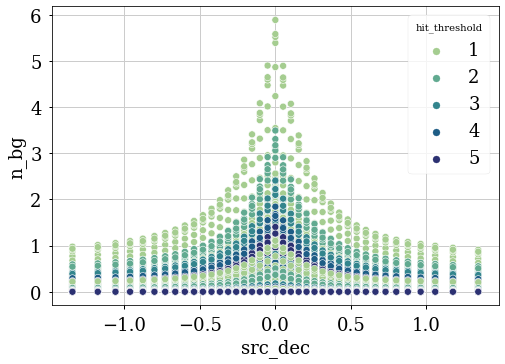

In [23]:
ax = sns.scatterplot(
    data=n_events, x="src_dec", y="n_bg", hue="hit_threshold", palette="crest"
)


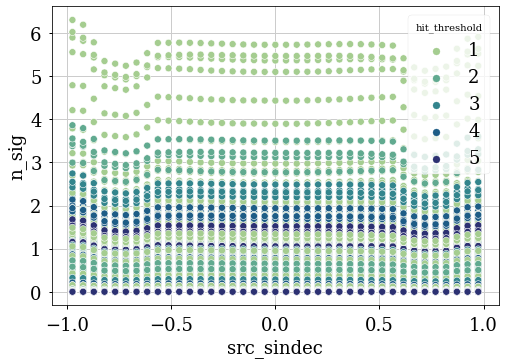

In [24]:
ax = sns.scatterplot(
    data=n_events, 
    x="src_sindec",
    y="n_sig",
    hue="hit_threshold",
    palette="crest",
)


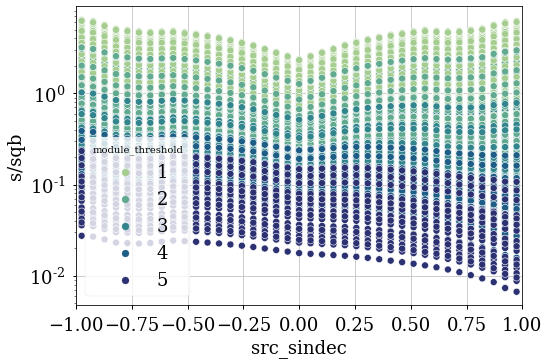

In [25]:
ax = sns.scatterplot(
    data=n_events, x="src_sindec", y="s/sqb", hue="module_threshold", palette="crest"
)
ax.set_xlim(-1, 1)
ax.set_yscale("log")


# simple PS fits at various decs

### llh definition

In [26]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0,
    phi_0,
    shape,
    normed_kvals,
    verbose=False,
):
    """fit parameters in x:
    x[0]: background normalization scaling
    x[1]: signal normalization scaling
    x[2:]: other signal parameters
        see 'astro_flux' for further shapes and parameters

    mu_b_base: background baseline
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_0: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    shape: flux shape
    """
    mu_b = mu_b_base * x[0]
    mu_s = astro_flux(
        mu_s_base,
        emids,
        normed_kvals,
        x[1],
        flux_collection[shape](
            phi_0, *x[2:], e_0, shape
        ),  # here we generate a flux tuple with the current parameters
    )
    if verbose:
        print(x[0], x[1], *x[2:])
        print(flux_collection[shape](phi_0, *x[2:], e_0, shape))
        print(np.sum(mu_b), np.sum(mu_s))
    mu_i = mu_s + mu_b

    return -2 * np.sum(
        np.where(
            np.logical_and(mu_i > 0, k_i > 0),
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )


## point-source vs uniform atmospheric

In [28]:
resolution_df = pd.read_pickle(
    join(BASEPATH, "resources/optimization_resolutions.pickle")
)
resolution_df = resolution_df.set_index(["config", "spacing", "pmts"])


### testing one config

In [29]:
i = 50
aeff_test = aeffs.iloc[i]["equatorial"] * 7 # full detector
config = aeffs.index[i]
c_names = np.asarray(aeffs.index.names)
# config is: 'full pessimistic cluster' and 16 PMTs for aeffs
print(aeffs.loc[config], c_names)
reso_test = resolution_df.loc["Full pessimistic cluster", config[-1], 16]
print(reso_test.name)
bckg_grid = np.ones_like(reso_test.psi2)
bckg_grid /= np.sum(bckg_grid, axis=0)


aeff_hist     [[0.012907542558880266, 0.01597975130950434, 0...
equatorial    [[114.37128603830939, 115.41494100146402, 108....
Name: (1, 1, nan, 50.0), dtype: object ['hit_threshold' 'module_threshold' 'min_pos_resolution' 'spacing']
('Full pessimistic cluster', 50.0, 16)


In [32]:
src_config["grid_2d"] = reso_test.psi2
ngc_src_config["grid_2d"] = reso_test.psi2

bg_config["grid_2d"] = bckg_grid
ngc_bg_config["grid_2d"] = bckg_grid

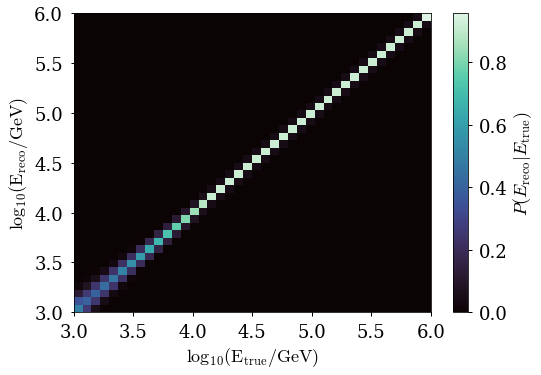

In [30]:
plt.pcolormesh(reso_test.etrue_bins, reso_test.ereco_bins, reso_test.energy_res)
plt.xlabel(r"$\rm log_{10} (E_{\rm true}/GeV)$")
plt.ylabel(r"$\rm log_{10} (E_{\rm reco}/GeV)$")
cb = plt.colorbar()
cb.set_label(r"$P( E_{\rm reco} | E_{\rm true})$")

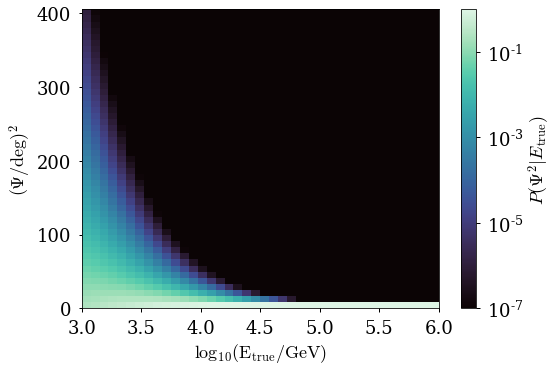

In [31]:
plt.pcolormesh(reso_test.etrue_bins, reso_test.psi2_bins, reso_test.psi2, norm=LogNorm(vmin=1E-7, clip=True))
plt.xlabel(r"$\rm log_{10} (E_{\rm true}/GeV)$")
plt.ylabel(r"$(\Psi / {\rm deg})^2$")
cb = plt.colorbar()
cb.set_label(r"$P(\Psi^2 | E_{\rm true})$")

LIVETIME: 10.0
source: NGC 1068
Asimov data sum: Background= 21.84711170285292 , Signal: 19.647493811888225
Atmo-only normalization: [1.89933486]
Signal fit parameters: [1.00004847 0.99998324 3.1999761 ]
-2 Delta LLH: 50.72299438826485
P-VALUE: 9.674793759064916e-12 SIGNIFICANCE: 6.811257501984538



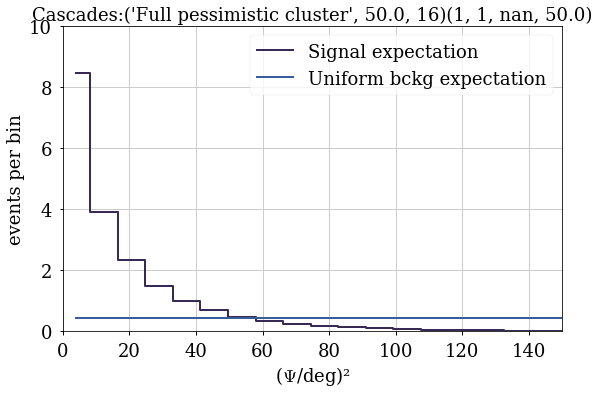

In [33]:
print("LIVETIME:", LIVETIME / 3600 / 24 / 365)
print("source: NGC 1068")
aeff_factor_bckg = calc_aeff_factor(aeff_test, **ngc_bg_config)
aeff_factor_signal = calc_aeff_factor(aeff_test, **ngc_src_config)

# asimov data
k_b = atmo_background(
    aeff_factor_bckg,
    array_source_interp(ngc1068.dec.rad, spl_vals.T, sindec_mids).T,
    normed_kvals=reso_test.energy_res,
)
k_s = astro_flux(
    aeff_factor_signal,
    emids,
    phi_scaling=1,
    normed_kvals=reso_test.energy_res,
    flux_shape=ngc_flux,  # powerlaw
)
k_i = k_s + k_b

print("Asimov data sum: Background=", np.sum(k_b), ", Signal:", np.sum(k_s))
# fix signal contribution to 0
fit_config = dict(
    shape="powerlaw",
    mu_b_base=k_b,
    mu_s_base=aeff_factor_signal,
    k_i=k_i,
    e_0=ngc_flux.E0,
    phi_0=ngc_flux.norm,
    normed_kvals=reso_test.energy_res,
)
local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 3), **fit_config)
global_llh = lambda x: ps_llh_2d_composite(x, **fit_config)
out_bckg = fmin_l_bfgs_b(
    local_llh,
    x0=(1.2,),
    approx_grad=True,
)
print("Atmo-only normalization:", out_bckg[0])

out_comp = fmin_l_bfgs_b(
    global_llh,
    x0=(1.2, 1.2, 3.0),
    approx_grad=True,
)
print("Signal fit parameters:", out_comp[0])
print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
significance = erfinv(1 - pval) * np.sqrt(2)
print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
print("")

psi2_mids = get_mids(reso_test.psi2_bins)
plt.figure()
plt.title("Cascades:" + str(reso_test.name) + str(config))
plt.plot(psi2_mids, np.sum(k_s, axis=-1), ds="steps-mid", label="Signal expectation")
plt.plot(
    psi2_mids, np.sum(k_b, axis=-1), ds="steps-mid", label="Uniform bckg expectation"
)
plt.xlabel(r"($\Psi$/deg)²")
plt.ylabel("events per bin")
plt.xlim(0, 150)
plt.ylim(0, 10)
plt.legend()
plt.tight_layout()


# Full PS setup - NGC 1068

In [36]:
c_names = np.asarray(aeffs.index.names)
mask = aeffs.index.get_level_values("spacing") >= 50

for full_det in [False, True]:
    ps_significances = []
    for config, aeff in aeffs.loc[mask].iterrows():
        if full_det:
            aeff *= 7  # full detector
        tmp = {key: val for key, val in zip(c_names, config)}
        aeff_test = aeff["equatorial"]
        reso_test = resolution_df.loc["Full pessimistic cluster", config[-1], 16]
        bckg_grid = np.ones_like(reso_test.psi2)
        bckg_grid /= np.sum(bckg_grid, axis=0)
        ngc_bg_config["grid_2d"] = bckg_grid
        ngc_src_config["grid_2d"] = reso_test.psi2
        aeff_factor_bckg = calc_aeff_factor(aeff_test, **ngc_bg_config)
        aeff_factor_signal = calc_aeff_factor(aeff_test, **ngc_src_config)

        # asimov data
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(ngc1068.dec.rad, spl_vals.T, sindec_mids).T,
            normed_kvals=reso_test.energy_res,
        )
        k_s = astro_flux(
            aeff_factor_signal,
            emids,
            phi_scaling=1,
            normed_kvals=reso_test.energy_res,
            flux_shape=ngc_flux,  # powerlaw
        )
        k_i = k_s + k_b

        tmp["nb"] = np.sum(k_b)
        tmp["ns"] = np.sum(k_s)

        # fix signal contribution to 0
        fit_config = dict(
            shape="powerlaw",
            mu_b_base=k_b,
            mu_s_base=aeff_factor_signal,
            k_i=k_i,
            e_0=ngc_flux.E0,
            phi_0=ngc_flux.norm,
            normed_kvals=reso_test.energy_res,
        )
        local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 3), **fit_config)
        global_llh = lambda x: ps_llh_2d_composite(x, **fit_config)
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.2,),
            approx_grad=True,
        )
        tmp["out_bg"] = out_bckg[0]

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.2, 1.2, 3.0),
            approx_grad=True,
        )
        tmp["out_sig"] = out_comp[0]
        tmp["-2DLLH"] = out_bckg[1] - out_comp[1]

        pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
        significance = erfinv(1 - pval) * np.sqrt(2)
        tmp["pval"] = pval
        tmp["sigma"] = significance
        ps_significances.append(tmp)
    ps_significances = pd.DataFrame(ps_significances)
    ps_significances["comb_threshold"] = np.asarray(
        ps_significances.hit_threshold + ps_significances.module_threshold * 10,
        dtype=int,
    )

    ps_significances["sigma_cut"] = 7
    ps_significances.loc[
        ps_significances["sigma"] <= 7, "sigma_cut"
    ] = ps_significances.loc[ps_significances["sigma"] <= 7, "sigma"]
    add = "full" if full_det else "cluster"
    pd.to_pickle(
        ps_significances, join(BASEPATH, f"resources/casc_ps_significance_{add}.pckl")
    )


In [37]:
ps_significances_full = pd.read_pickle(
    join(BASEPATH, "resources/casc_ps_significance_full.pckl")
)
ps_significances_cluster = pd.read_pickle(
    join(BASEPATH, "resources/casc_ps_significance_cluster.pckl")
)


## plotting

In [38]:
selection = ps_significances_full

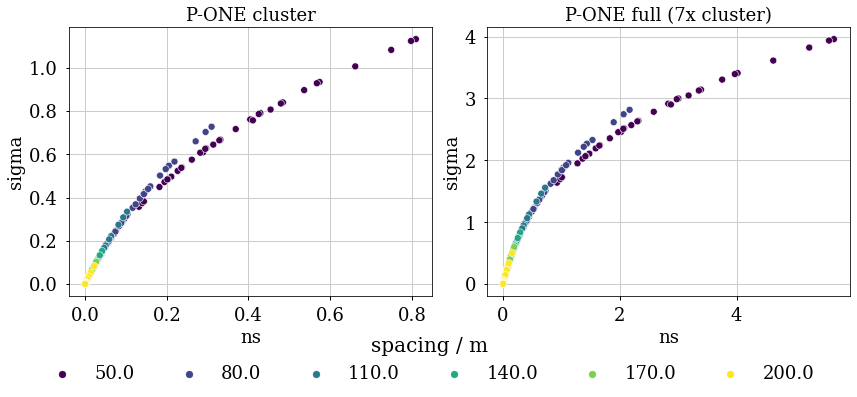

In [40]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
ax = sns.scatterplot(
    data=ps_significances_cluster.loc[
        (ps_significances_cluster.hit_threshold >= 3)
        & (ps_significances_cluster.module_threshold >= 3)
    ],
    x="ns",
    y="sigma",
    hue="spacing",
    palette="viridis",
    ax=ax1,
)
ax.set_title("P-ONE cluster")
legend = f.legend(
    ncol=6,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.1),
    title="spacing / m",
    frameon=False,
)
legend.get_title().set_fontsize(20)
ax.legend([], frameon=False)
ax = sns.scatterplot(
    data=ps_significances_full.loc[
        (ps_significances_full.hit_threshold >= 3)
        & (ps_significances_full.module_threshold >= 3)
    ],
    x="ns",
    y="sigma",
    hue="spacing",
    palette="viridis",
    ax=ax2,
)
ax.set_title("P-ONE full (7x cluster)")
ax.legend([], frameon=False)

plt.tight_layout()


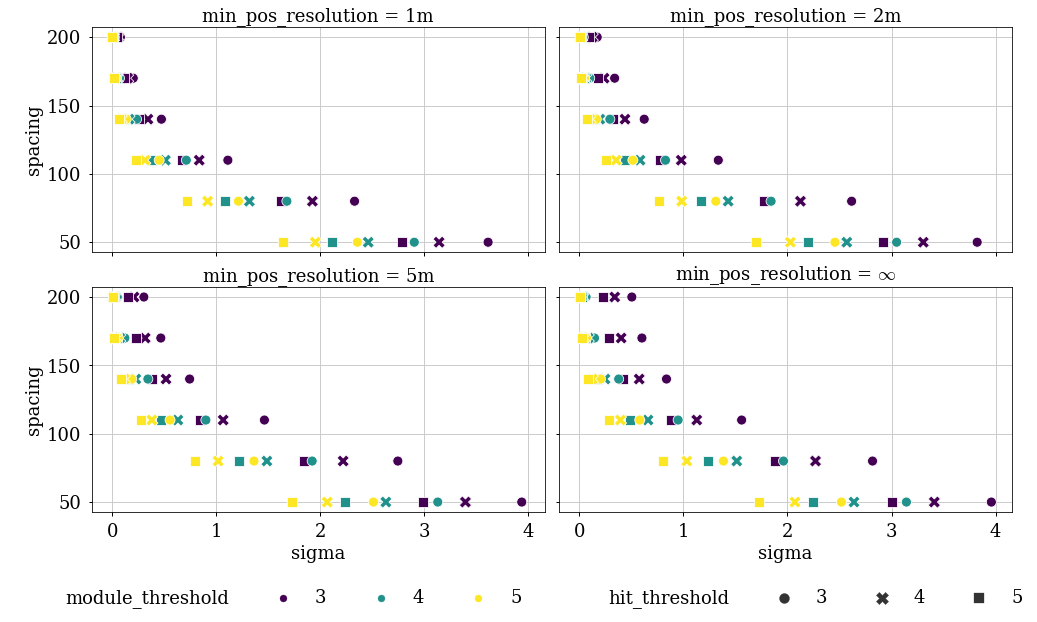

In [42]:
selection = ps_significances_full.loc[(ps_significances_full.hit_threshold >= 3) & (ps_significances_full.module_threshold >= 3)]

f, axes = plt.subplots(figsize=(14, 8), ncols=2, nrows=2, sharex=True, sharey=True)
ncols = len(selection.module_threshold.unique())

condition = [
    ("min_pos_resolution = 1m", selection.min_pos_resolution == 1),
    ("min_pos_resolution = 2m", selection.min_pos_resolution == 2),
    ("min_pos_resolution = 5m", selection.min_pos_resolution == 5),
    (r"min_pos_resolution = $\infty$", selection.min_pos_resolution.isna()),
]


for ii, ax in enumerate(axes.flatten()):

    ax = sns.scatterplot(
        data=selection.loc[condition[ii][1]],
        x="sigma",
        y="spacing",
        hue="module_threshold",
        style="hit_threshold",
        size="hit_threshold",
        sizes=(100, 200),
        palette="viridis",
        ax=ax,
    )
    #ax.set_xscale("log")
    ax.set_title(condition[ii][0])

    if ii==0:
        f.legend(
        ncol=8, loc="upper center", bbox_to_anchor=(0.5, 0.0), frameon=False, fontsize=18
    )
    ax.legend([], frameon=False)


f.tight_layout()
f.savefig(join(BASEPATH, "plots/cascades_ps_significances.png"))


# scan over declinations

In [43]:
src_decs = np.deg2rad(np.linspace(-75, 75, 11))
c_names = np.asarray(aeffs.index.names)
# selection
mask = aeffs.index.get_level_values("spacing") >= 50
mask &= aeffs.index.get_level_values("hit_threshold") >= 3
mask &= aeffs.index.get_level_values("module_threshold") >= 3

# full detector = 7 cluster
full_det = True

ps_significances = []
for src_dec in src_decs:
    for config, aeff in aeffs.loc[mask].iterrows():
        if full_det:
            aeff *= 7  # full detector
        tmp = {key: val for key, val in zip(c_names, config)}
        tmp["dec"] = src_dec
        aeff_test = aeff["equatorial"]
        reso_test = resolution_df.loc["Full pessimistic cluster", config[-1], 16]
        bckg_grid = np.ones_like(reso_test.psi2)
        bckg_grid /= np.sum(bckg_grid, axis=0)

        bg_config["grid_2d"] = bckg_grid
        bg_config["dec"] = src_dec
        src_config["grid_2d"] = reso_test.psi2
        src_config["dec"] = src_dec

        aeff_factor_bckg = calc_aeff_factor(aeff_test, **bg_config)
        aeff_factor_signal = calc_aeff_factor(aeff_test, **src_config)

        # asimov data
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(src_dec, spl_vals.T, sindec_mids).T,
            normed_kvals=reso_test.energy_res,
        )
        k_s = astro_flux(
            aeff_factor_signal,
            emids,
            phi_scaling=1,
            normed_kvals=reso_test.energy_res,
            flux_shape=ngc_flux,  # powerlaw
        )
        k_i = k_s + k_b

        tmp["nb"] = np.sum(k_b)
        tmp["ns"] = np.sum(k_s)

        # fix signal contribution to 0
        fit_config = fit_config = dict(
            shape="powerlaw",
            mu_b_base=k_b,
            mu_s_base=aeff_factor_signal,
            k_i=k_i,
            e_0=ngc_flux.E0,
            phi_0=ngc_flux.norm,
            normed_kvals=reso_test.energy_res,
        )
        local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 3), **fit_config)
        global_llh = lambda x: ps_llh_2d_composite(x, **fit_config)
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.2,),
            approx_grad=True,
        )
        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.2, 1.2, 3.0),
            approx_grad=True,
        )
        pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
        significance = erfinv(1 - pval) * np.sqrt(2)

        tmp["out_bg"] = out_bckg[0]
        tmp["out_sig"] = out_comp[0]
        tmp["-2DLLH"] = out_bckg[1] - out_comp[1]
        tmp["pval"] = pval
        tmp["sigma"] = significance
        ps_significances.append(tmp)

ps_significances = pd.DataFrame(ps_significances)
ps_significances["sigma_cut"] = 7
ps_significances.loc[
    ps_significances["sigma"] <= 7, "sigma_cut"
] = ps_significances.loc[ps_significances["sigma"] <= 7, "sigma"]
add = "full" if full_det else "cluster"
ps_significances["sindec"] = np.sin(ps_significances["dec"])
pd.to_pickle(
    ps_significances,
    join(BASEPATH, f"resources/casc_ps_significance_ngc_{add}_dec-scan.pckl"),
)


In [44]:
ps_significances = pd.read_pickle(
    join(BASEPATH, "resources/casc_ps_significance_ngc_full_dec-scan.pckl")
)
ps_significances["sindec"] = np.sin(ps_significances["dec"])


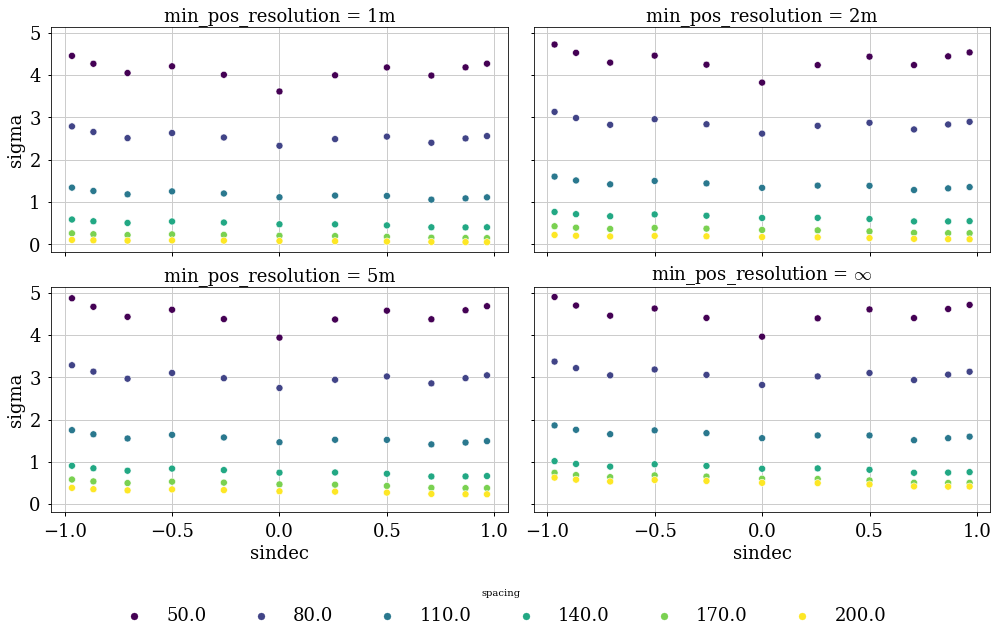

In [45]:
mask = ps_significances.hit_threshold == 3
mask &= ps_significances.module_threshold == 3
selection = ps_significances.loc[mask]
f, axes = plt.subplots(figsize=(14, 8), ncols=2, nrows=2, sharex=True, sharey=True)
ncols = len(selection.module_threshold.unique())

condition = [
    ("min_pos_resolution = 1m", selection.min_pos_resolution == 1),
    ("min_pos_resolution = 2m", selection.min_pos_resolution == 2),
    ("min_pos_resolution = 5m", selection.min_pos_resolution == 5),
    (r"min_pos_resolution = $\infty$", selection.min_pos_resolution.isna()),
]


for ii, ax in enumerate(axes.flatten()):

    ax = sns.scatterplot(
        data=selection.loc[condition[ii][1]],
        x="sindec",
        y="sigma",
        hue="spacing",
        #style="hit_threshold",
        #size="hit_threshold",
        #sizes=(100, 200),
        palette="viridis",
        ax=ax,
    )
    #ax.set_xscale("log")
    ax.set_title(condition[ii][0])

    if ii==0:
        f.legend(
        ncol=8, loc="upper center", bbox_to_anchor=(0.5, 0.0), frameon=False, fontsize=18, title="spacing"
    )
    ax.legend([], frameon=False)


f.tight_layout()

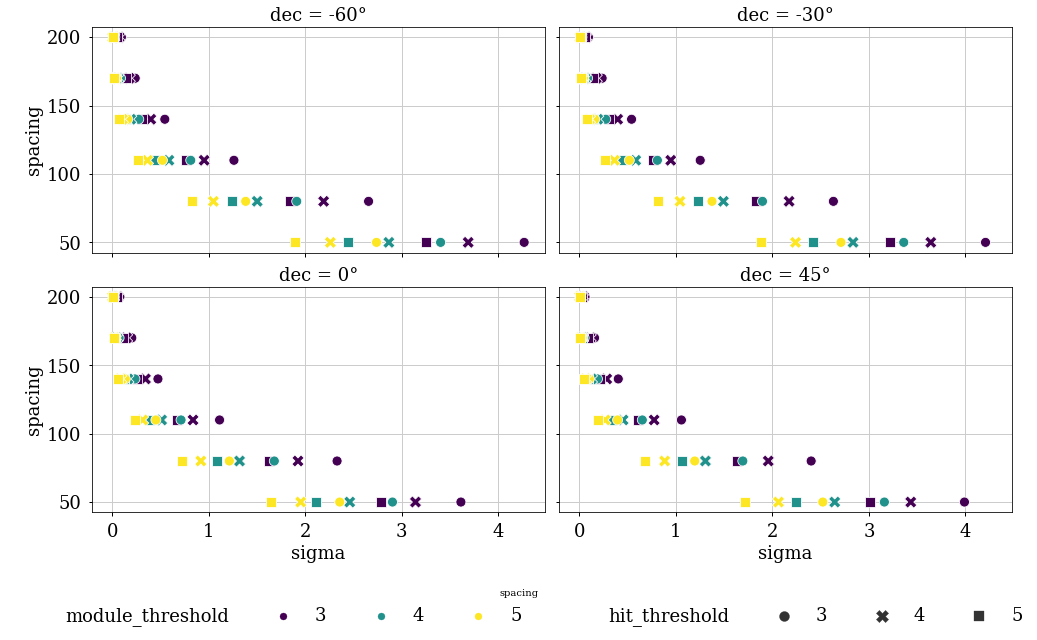

In [46]:
mask = ps_significances.hit_threshold >= 3
mask &= ps_significances.module_threshold >= 3
mask &= ps_significances.min_pos_resolution == 1
selection = ps_significances.loc[mask]
f, axes = plt.subplots(figsize=(14, 8), ncols=2, nrows=2, sharex=True, sharey=True)
ncols = len(selection.module_threshold.unique())

condition = [
    ("dec = -60°", selection.dec == np.deg2rad(-60)),
    ("dec = -30°", selection.dec == np.deg2rad(-30)),
    ("dec = 0°", selection.dec == np.deg2rad(0)),
    ("dec = 45°", selection.dec == np.deg2rad(45)),
]


for ii, ax in enumerate(axes.flatten()):

    ax = sns.scatterplot(
        data=selection.loc[condition[ii][1]],
        x="sigma",
        y="spacing",
        hue="module_threshold",
        style="hit_threshold",
        size="hit_threshold",
        sizes=(100, 200),
        palette="viridis",
        ax=ax,
    )
    #ax.set_xscale("log")
    ax.set_title(condition[ii][0])

    if ii==0:
        f.legend(
        ncol=8, loc="upper center", bbox_to_anchor=(0.5, 0.0), frameon=False, fontsize=18, title="spacing"
    )
    ax.legend([], frameon=False)


f.tight_layout()

# Hard-spectrum source (TXS-like)

In [48]:
# TXS parameters
with open(join(BASEPATH, "resources/txs_contour.pkl"), "rb") as f:
    txs_contour = pickle.load(f)

GAMMA_TXS = txs_contour["best-fit"][0]
PHI_TXS = txs_contour["best-fit"][1] / 1E3 / 3 # fudge factor. # @ 1 TeV / GeV cm² s
E0_TXS = txs_contour["E0"] 

print(GAMMA_TXS, PHI_TXS, E0_TXS)
txs_flux = PL_flux(PHI_TXS, GAMMA_TXS, E0_TXS, "powerlaw")

1.9909560723514212 2.7045650301464248e-20 100000.0


In [49]:
src_decs = np.deg2rad(np.linspace(-75, 75, 11))
c_names = np.asarray(aeffs.index.names)
# selection
mask = aeffs.index.get_level_values("spacing") >= 50
mask &= aeffs.index.get_level_values("hit_threshold") >= 3
mask &= aeffs.index.get_level_values("module_threshold") >= 3

# full detector = 7 cluster
full_det = True

ps_significances = []
for src_dec in src_decs:
    for config, aeff in aeffs.loc[mask].iterrows():
        if full_det:
            aeff *= 7  # full detector
        tmp = {key: val for key, val in zip(c_names, config)}
        tmp["dec"] = src_dec
        aeff_test = aeff["equatorial"]
        reso_test = resolution_df.loc["Full pessimistic cluster", config[-1], 16]
        bckg_grid = np.ones_like(reso_test.psi2)
        bckg_grid /= np.sum(bckg_grid, axis=0)

        bg_config["grid_2d"] = bckg_grid
        bg_config["dec"] = src_dec
        src_config["grid_2d"] = reso_test.psi2
        src_config["dec"] = src_dec

        aeff_factor_bckg = calc_aeff_factor(aeff_test, **bg_config)
        aeff_factor_signal = calc_aeff_factor(aeff_test, **src_config)

        # asimov data
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(src_dec, spl_vals.T, sindec_mids).T,
            normed_kvals=reso_test.energy_res,
        )
        k_s = astro_flux(
            aeff_factor_signal,
            emids,
            phi_scaling=1,
            normed_kvals=reso_test.energy_res,
            flux_shape=txs_flux,  # powerlaw
        )
        k_i = k_s + k_b

        tmp["nb"] = np.sum(k_b)
        tmp["ns"] = np.sum(k_s)

        fit_config = fit_config = dict(
            shape="powerlaw",
            mu_b_base=k_b,
            mu_s_base=aeff_factor_signal,
            k_i=k_i,
            e_0=ngc_flux.E0,
            phi_0=ngc_flux.norm,
            normed_kvals=reso_test.energy_res,
        )
        local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 2), **fit_config)
        global_llh = lambda x: ps_llh_2d_composite(x, **fit_config)
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.2,),
            approx_grad=True,
        )
        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.2, 1.2, 2.0),
            approx_grad=True,
        )
        pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
        significance = erfinv(1 - pval) * np.sqrt(2)

        tmp["out_bg"] = out_bckg[0]
        tmp["out_sig"] = out_comp[0]
        tmp["-2DLLH"] = out_bckg[1] - out_comp[1]
        tmp["pval"] = pval
        tmp["sigma"] = significance
        ps_significances.append(tmp)
ps_significances = pd.DataFrame(ps_significances)
ps_significances["sigma_cut"] = 7
ps_significances.loc[
    ps_significances["sigma"] <= 7, "sigma_cut"
] = ps_significances.loc[ps_significances["sigma"] <= 7, "sigma"]
add = "full" if full_det else "cluster"
ps_significances["sindec"] = np.sin(ps_significances["dec"])
pd.to_pickle(
    ps_significances,
    join(BASEPATH, f"resources/casc_ps_significance_txs_{add}_dec-scan.pckl"),
)


In [50]:
ps_significances = pd.read_pickle(
    join(BASEPATH, "resources/casc_ps_significance_txs_full_dec-scan.pckl")
)
ps_significances["sindec"] = np.sin(ps_significances["dec"])


## dec scans

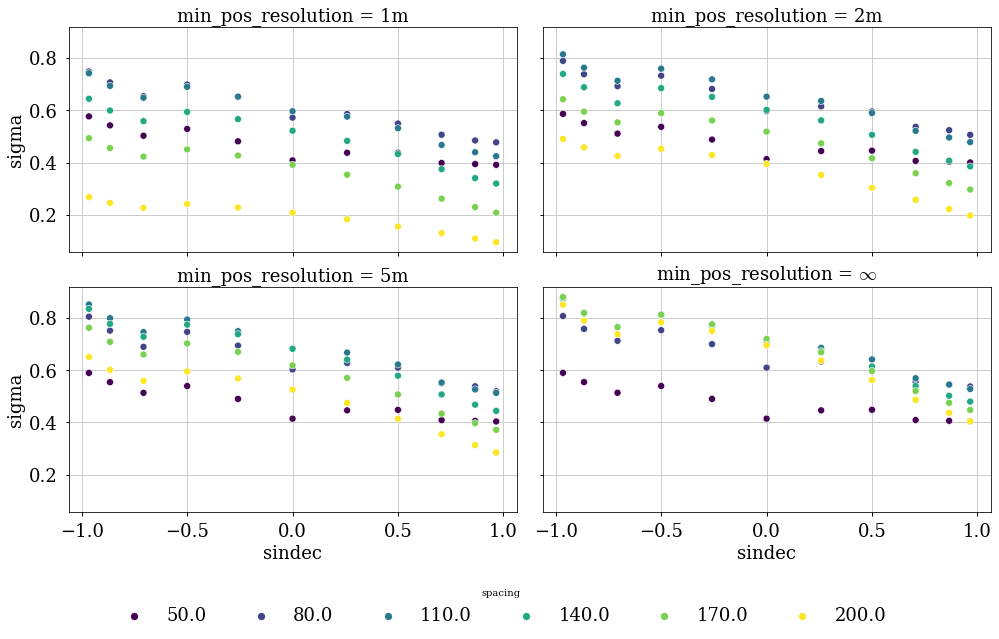

In [51]:
mask = ps_significances.hit_threshold == 3
mask &= ps_significances.module_threshold == 3
selection = ps_significances.loc[mask]
f, axes = plt.subplots(figsize=(14, 8), ncols=2, nrows=2, sharex=True, sharey=True)
ncols = len(selection.module_threshold.unique())

condition = [
    ("min_pos_resolution = 1m", selection.min_pos_resolution == 1),
    ("min_pos_resolution = 2m", selection.min_pos_resolution == 2),
    ("min_pos_resolution = 5m", selection.min_pos_resolution == 5),
    (r"min_pos_resolution = $\infty$", selection.min_pos_resolution.isna()),
]


for ii, ax in enumerate(axes.flatten()):

    ax = sns.scatterplot(
        data=selection.loc[condition[ii][1]],
        x="sindec",
        y="sigma",
        hue="spacing",
        #style="hit_threshold",
        #size="hit_threshold",
        #sizes=(100, 200),
        palette="viridis",
        ax=ax,
    )
    #ax.set_xscale("log")
    ax.set_title(condition[ii][0])

    if ii==0:
        f.legend(
        ncol=8, loc="upper center", bbox_to_anchor=(0.5, 0.0), frameon=False, fontsize=18, title="spacing"
    )
    ax.legend([], frameon=False)


f.tight_layout()

## trigger scan

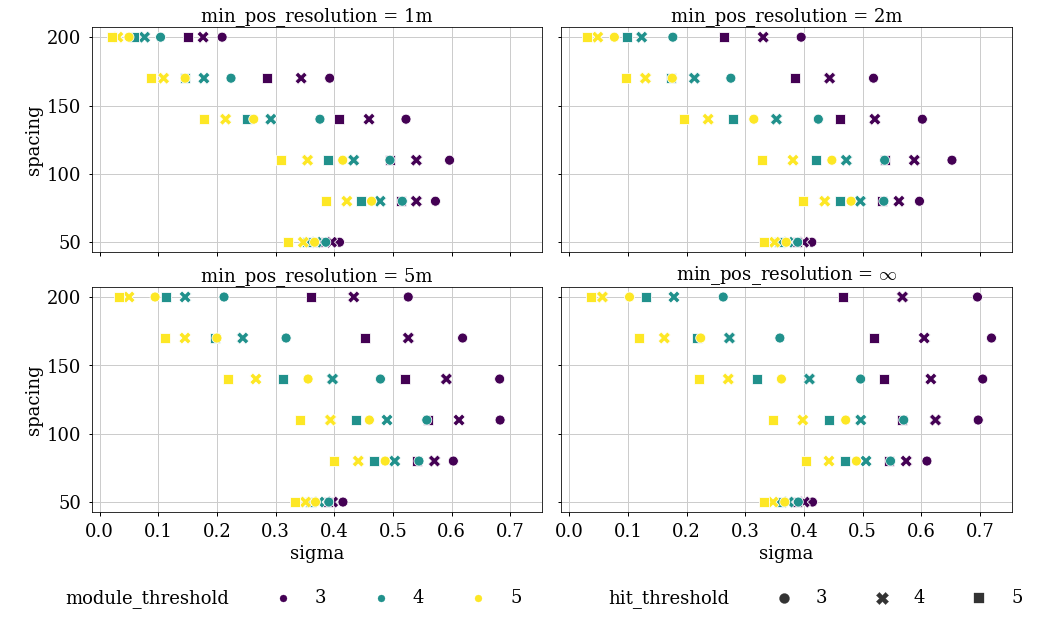

In [52]:
mask = ps_significances.hit_threshold >= 3
mask &= ps_significances.module_threshold >= 3
mask &= ps_significances.dec == 0
selection = ps_significances.loc[mask]

f, axes = plt.subplots(figsize=(14, 8), ncols=2, nrows=2, sharex=True, sharey=True)
ncols = len(selection.module_threshold.unique())

condition = [
    ("min_pos_resolution = 1m", selection.min_pos_resolution == 1),
    ("min_pos_resolution = 2m", selection.min_pos_resolution == 2),
    ("min_pos_resolution = 5m", selection.min_pos_resolution == 5),
    (r"min_pos_resolution = $\infty$", selection.min_pos_resolution.isna()),
]


for ii, ax in enumerate(axes.flatten()):

    ax = sns.scatterplot(
        data=selection.loc[condition[ii][1]],
        x="sigma",
        y="spacing",
        hue="module_threshold",
        style="hit_threshold",
        size="hit_threshold",
        sizes=(100, 200),
        palette="viridis",
        ax=ax,
    )
    #ax.set_xscale("log")
    ax.set_title(condition[ii][0])

    if ii==0:
        f.legend(
        ncol=8, loc="upper center", bbox_to_anchor=(0.5, 0.0), frameon=False, fontsize=18
    )
    ax.legend([], frameon=False)


f.tight_layout()


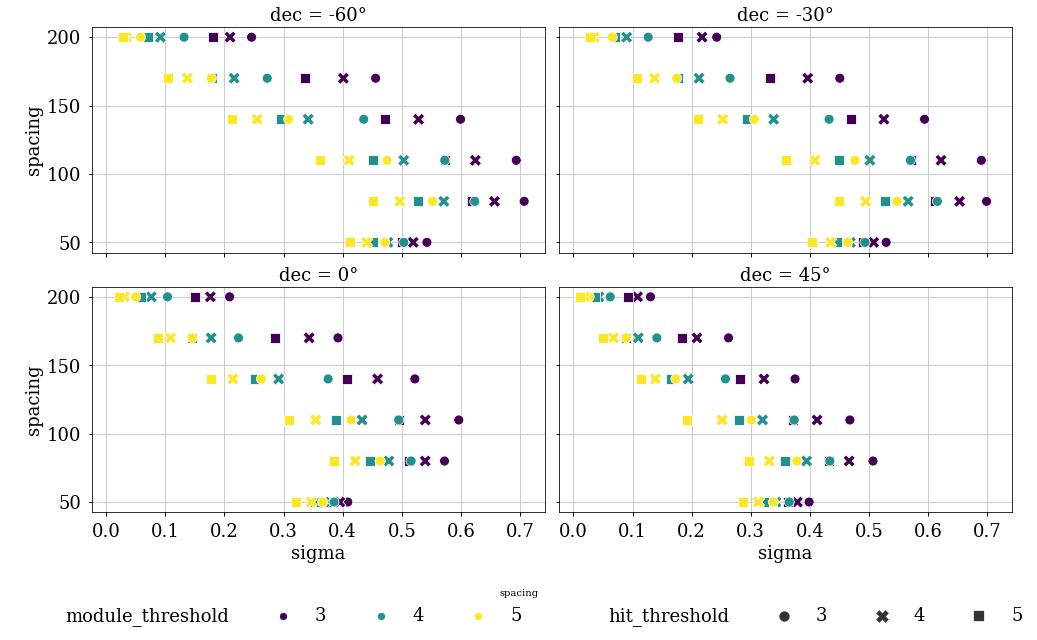

In [53]:
mask = ps_significances.hit_threshold >= 3
mask &= ps_significances.module_threshold >= 3
mask &= ps_significances.min_pos_resolution == 1
selection = ps_significances.loc[mask]
f, axes = plt.subplots(figsize=(14, 8), ncols=2, nrows=2, sharex=True, sharey=True)
ncols = len(selection.module_threshold.unique())

condition = [
    ("dec = -60°", selection.dec == np.deg2rad(-60)),
    ("dec = -30°", selection.dec == np.deg2rad(-30)),
    ("dec = 0°", selection.dec == np.deg2rad(0)),
    ("dec = 45°", selection.dec == np.deg2rad(45)),
]


for ii, ax in enumerate(axes.flatten()):

    ax = sns.scatterplot(
        data=selection.loc[condition[ii][1]],
        x="sigma",
        y="spacing",
        hue="module_threshold",
        style="hit_threshold",
        size="hit_threshold",
        sizes=(100, 200),
        palette="viridis",
        ax=ax,
    )
    #ax.set_xscale("log")
    ax.set_title(condition[ii][0])

    if ii==0:
        f.legend(
        ncol=8, loc="upper center", bbox_to_anchor=(0.5, 0.0), frameon=False, fontsize=18, title="spacing"
    )
    ax.legend([], frameon=False)


f.tight_layout()

# NGC and TXS comparison

In [54]:
ps_significances_txs = pd.read_pickle(
    join(BASEPATH, "resources/casc_ps_significance_txs_full_dec-scan.pckl")
)
ps_significances_txs["sindec"] = np.sin(ps_significances_txs["dec"])

ps_significances_ngc = pd.read_pickle(
    join(BASEPATH, "resources/casc_ps_significance_ngc_full_dec-scan.pckl")
)
ps_significances_ngc["sindec"] = np.sin(ps_significances_ngc["dec"])


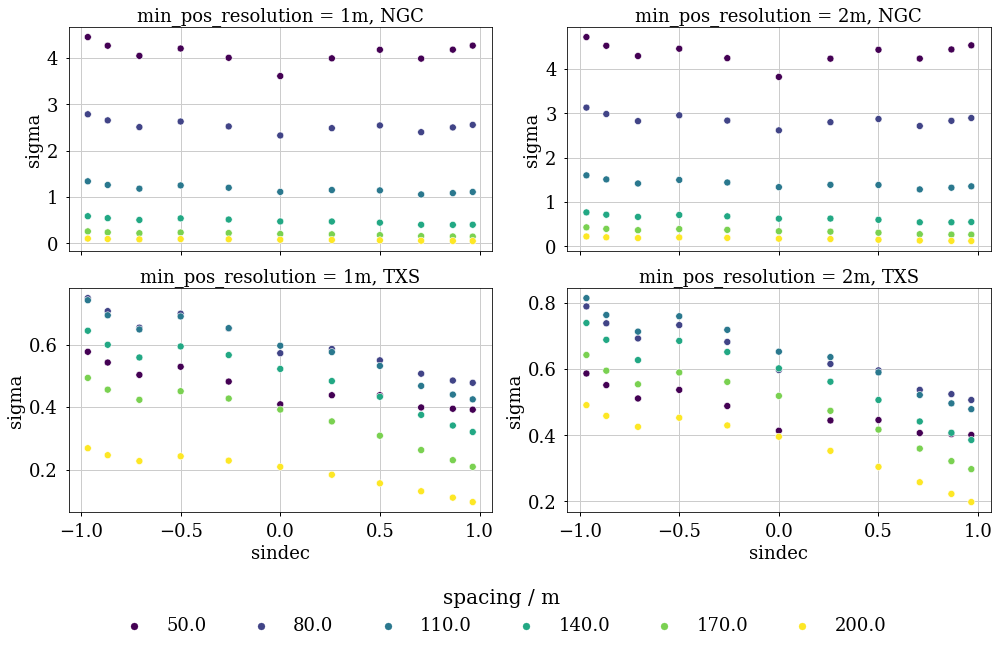

In [55]:

f, axes = plt.subplots(figsize=(14, 8), ncols=2, nrows=2, sharex=True, sharey=False)

for ii, ax in enumerate(axes.flatten()):
    if ii == 0:
        selection = ps_significances_ngc
        mask = selection.min_pos_resolution == 1
        label = "min_pos_resolution = 1m, NGC"
    elif ii==1:
        selection = ps_significances_ngc
        mask = selection.min_pos_resolution == 2
        label = "min_pos_resolution = 2m, NGC"
    elif ii==2:
        selection = ps_significances_txs
        mask = selection.min_pos_resolution == 1
        label = "min_pos_resolution = 1m, TXS"
    else:
        selection = ps_significances_txs
        mask = selection.min_pos_resolution == 2
        label = "min_pos_resolution = 2m, TXS"

    mask &= selection.hit_threshold == 3
    mask &= selection.module_threshold == 3
    selection = selection.loc[mask]
    ax = sns.scatterplot(
        data=selection,
        x="sindec",
        y="sigma",
        hue="spacing",
        palette="viridis",
        ax=ax,
    )
    #ax.set_xscale("log")
    ax.set_title(label)

    if ii==0:
        legend=f.legend(
        ncol=8, loc="upper center", bbox_to_anchor=(0.5, 0.0), frameon=False, fontsize=18, title="spacing / m"
    )
        legend.get_title().set_fontsize(20)
    ax.legend([], frameon=False)


f.tight_layout()